<a href="https://colab.research.google.com/github/nguyen-nhat-mai/ensemble_project/blob/main/Airbnb_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **AIRBNB PRICE PREDICTION**
By Haiwei FU, Mengyu LIANG, Nhat Mai NGUYEN, Jinji SHEN and Vanshika SHARMA

# **Setup**

In [7]:
# Please upload your kaggle.json file before running this cell
! pip install kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
! kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data

  0% 0.00/2.44M [00:00<?, ?B/s]
100% 2.44M/2.44M [00:00<00:00, 183MB/s]


In [9]:
! unzip /content/new-york-city-airbnb-open-data.zip

Archive:  /content/new-york-city-airbnb-open-data.zip
  inflating: AB_NYC_2019.csv         
  inflating: New_York_City_.png      


In [206]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import scipy.stats as stats
import statsmodels.api as sm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# **Data Exploration**

**Initial check**

In [137]:
# load dataset
df = pd.read_csv('/content/AB_NYC_2019.csv')
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [138]:
df.shape

(48895, 16)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

In [140]:
# check null value
df.isnull().sum()

id                                    0
name                                 16
host_id                               0
host_name                            21
neighbourhood_group                   0
neighbourhood                         0
latitude                              0
longitude                             0
room_type                             0
price                                 0
minimum_nights                        0
number_of_reviews                     0
last_review                       10052
reviews_per_month                 10052
calculated_host_listings_count        0
availability_365                      0
dtype: int64

In [141]:
# check duplicate
df.duplicated().sum()

0

In [142]:
# check numerical variables
num_var = ['latitude','longitude','minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365','price']
df[num_var].describe()

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
count,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000,48895.000000
mean,40.728949,-73.952170,7.029962,23.274466,1.373221,7.143982,112.781327,152.720687
std,0.054530,0.046157,20.510550,44.550582,1.680442,32.952519,131.622289,240.154170
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000,0.000000
25%,40.690100,-73.983070,1.000000,1.000000,0.190000,1.000000,0.000000,69.000000
50%,40.723070,-73.955680,3.000000,5.000000,0.720000,1.000000,45.000000,106.000000
75%,40.763115,-73.936275,5.000000,24.000000,2.020000,2.000000,227.000000,175.000000
max,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000,10000.000000


In [143]:
# check categorical variables (unique values, format consistency such as lower/uppercase, space,...)
print('Unique values per variable')
print(df[['name','host_name','neighbourhood_group','neighbourhood','room_type']].nunique())
print('\nUnique values in neighbourhood_group', df['neighbourhood_group'].unique())
print('Unique values in room_type', df['room_type'].unique())

Unique values per variable
name                   47905
host_name              11452
neighbourhood_group        5
neighbourhood            221
room_type                  3
dtype: int64

Unique values in neighbourhood_group ['Brooklyn' 'Manhattan' 'Queens' 'Staten Island' 'Bronx']
Unique values in room_type ['Private room' 'Entire home/apt' 'Shared room']


**Target variable: Price**

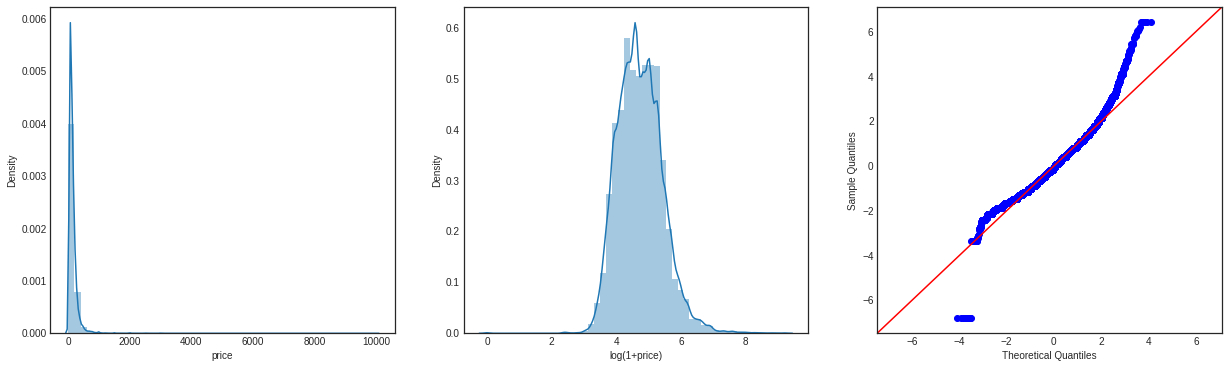

In [144]:
fig, axes = plt.subplots(1,3, figsize=(21,6))
sns.distplot(df['price'], ax=axes[0])
sns.distplot(np.log1p(df['price']), ax=axes[1])
axes[1].set_xlabel('log(1+price)')
sm.qqplot(np.log1p(df['price']), stats.norm, fit=True, line='45', ax=axes[2])
plt.show()

The distribution of price is highly skewed. By taking log, the variable seems to follow normal distribution.

In [145]:
df['log_price'] = np.log1p(df['price'])

**Distribution of other numerical variables**

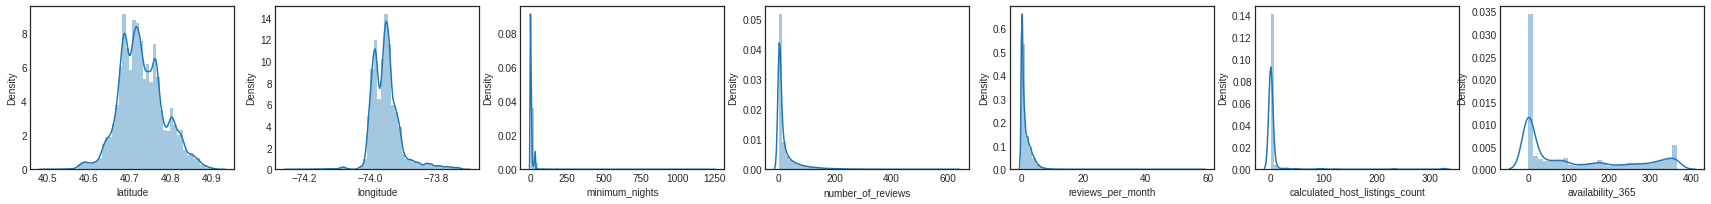

In [146]:
filter_num_var = num_var[:-1] # exclude price
f,ax = plt.subplots(1,7, figsize=(30,3))
for i in range(len(filter_num_var)):
  sns.distplot(df[filter_num_var[i]], ax=ax[i])
  ax[i].set_xlabel(filter_num_var[i])

Except for latitude and longtitude, distributions of the remaining variables are highly skewed

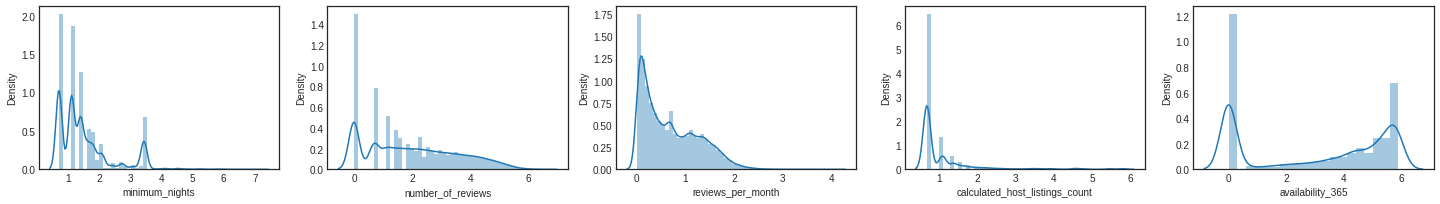

In [147]:
skewed_var = ['minimum_nights','number_of_reviews','reviews_per_month','calculated_host_listings_count','availability_365']
f,ax = plt.subplots(1,5, figsize=(25,3))
for i in range(len(skewed_var)):
  sns.distplot(np.log1p(df[skewed_var[i]]), ax=ax[i])
  ax[i].set_xlabel(skewed_var[i])

The data are too skewed that log transformation can not normalize the them. However, we can add these as potential features for trial & error in modeling part.

In [148]:
# Add log variables
df['log_minimum_nights'] = np.log1p(df['minimum_nights'])
df['log_number_of_reviews'] = np.log1p(df['number_of_reviews'])
df['log_reviews_per_month'] = np.log1p(df['reviews_per_month'])
df['log_calculated_host_listings_count'] = np.log1p(df['calculated_host_listings_count'])
df['log_availability_365'] = np.log1p(df['availability_365'])

Besides, since the variables are highly concentrated in certain values, other yes/no features such as no_review, fully_available, low_available, etc. can be extracted for trial and error as well.

In [149]:
# Add yes/no (1/0) variables
df['no_review'] = np.where(df['reviews_per_month'] > 0, 0, 1) # place without a review
df['minimum_night_1'] = np.where(df['minimum_nights'] == 1, 1, 0) # places requires minimum night of 1
df['host_listing_1'] = np.where(df['calculated_host_listings_count'] == 1, 1, 0) # host list only 1 place
df['availability_full'] = np.where(df['availability_365'] == 365, 1, 0) # availability = 365
df['availability_low'] = np.where(df['availability_365'] < 12, 1, 0) # available less than 1 day/month
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,...,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,...,0.693147,2.302585,0.190620,1.945910,5.902633,0,1,0,1,0
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.693147,3.828641,0.322083,1.098612,5.874931,0,1,0,0,0
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,...,1.386294,0.000000,NaN,0.693147,5.902633,1,0,1,1,0
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,0.693147,5.602119,1.729884,0.693147,5.273000,0,1,1,0,0
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,2.397895,2.302585,0.095310,0.693147,0.000000,0,0,1,0,1


**A map view of price distribution**

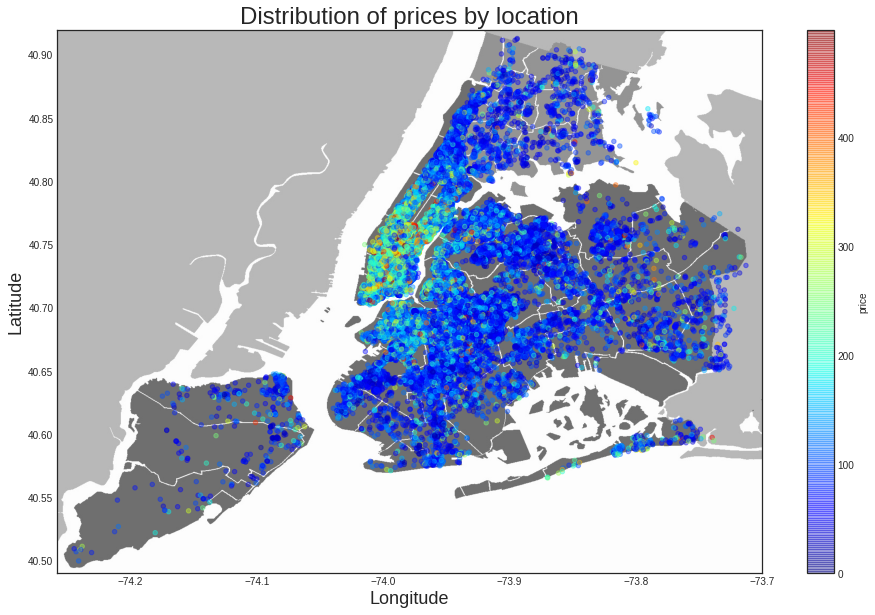

In [150]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.price < 500].plot(kind='scatter', x='longitude', y='latitude', c='price', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of prices by location', fontsize= 24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)

plt.show()

**A map view of the availability**

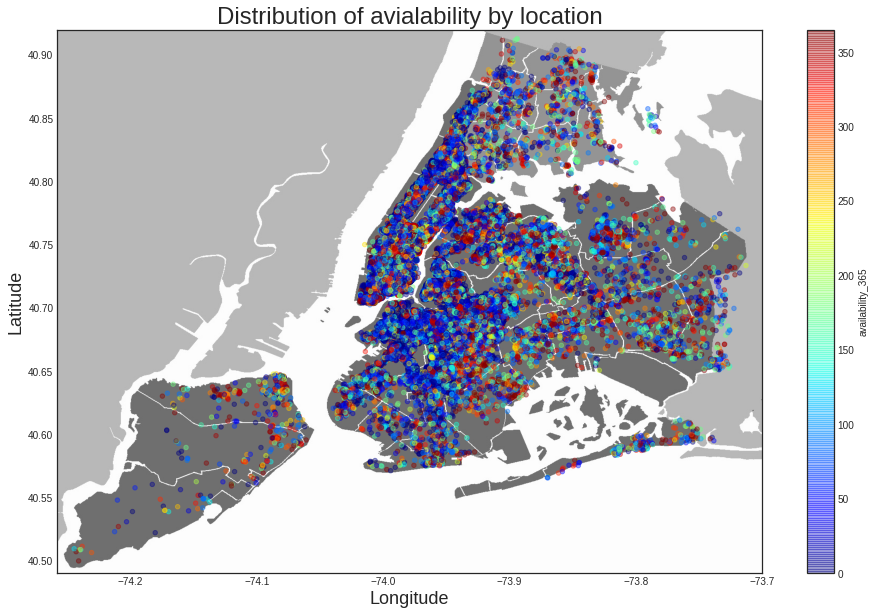

In [151]:
plt.figure(figsize=(16,10))
nyc_img=plt.imread("/content/New_York_City_.png", 0) #without the 0 we get an "invalid png header" error

#scaling the image based on the latitude and longitude max and mins for proper output
plt.imshow(nyc_img,zorder=0,extent=[-74.258, -73.7, 40.49,40.92])
ax=plt.gca()

#using scatterplot
df[df.availability_365>= 0].plot(kind='scatter', x='longitude', y='latitude', c='availability_365', ax=ax, 
           cmap=plt.get_cmap('jet'), colorbar=True, alpha=0.4, zorder=5)
plt.legend()
plt.title('Distribution of avialability by location', fontsize=24)
plt.xlabel('Longitude', fontsize = 18)
plt.ylabel('Latitude', fontsize = 18)
plt.show()

**Neighbourhood Groups**

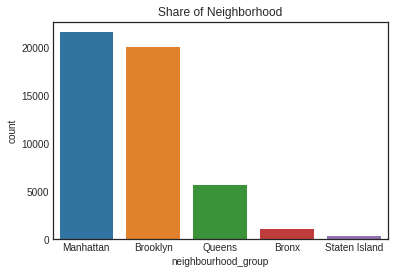

In [152]:
# visualize the number of Airbnbs in each borough
ax = sns.countplot('neighbourhood_group',data=df,order=df['neighbourhood_group'].value_counts().index)
ax.set_title('Share of Neighborhood')
plt.show()

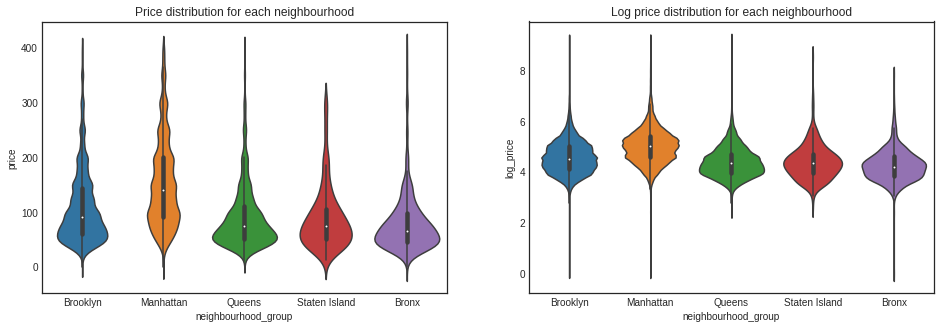

In [153]:
# create a sub-dataframe with no extreme values /
winsorized_df = df[df.price < 400]

# using violinplot to showcase density and distribtuion of prices
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='neighbourhood_group', y='price', ax=ax[0])
ax[0].set_title('Price distribution for each neighbourhood')
sns.violinplot(data=df, x='neighbourhood_group', y='log_price', ax=ax[1])
ax[1].set_title('Log price distribution for each neighbourhood')
plt.show()

We can see that Manhattan seems to have more of the higher priced properties. Bronx, Staten Island, and Queens have much more reasonable prices compared to Brooklyn and Manhattan. All distributions of price have positive skew while distributions of log(price) are quite normal.

**Room Type**

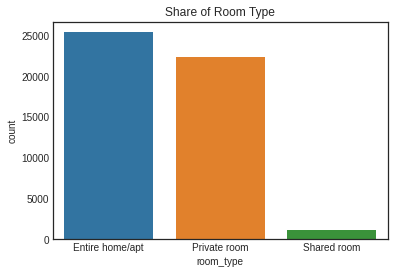

In [154]:
ax = sns.countplot('room_type',data=df,order=df['room_type'].value_counts().index)
ax.set_title('Share of Room Type')
plt.show()

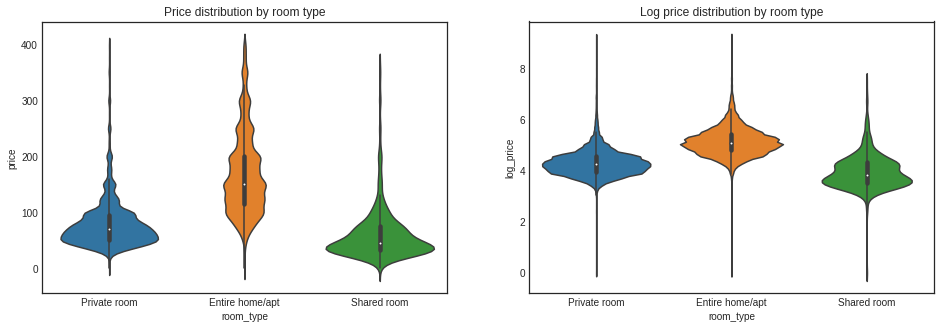

In [155]:
fig, ax = plt.subplots(1,2, figsize=(16,5))
sns.violinplot(data=winsorized_df, x='room_type', y='price',ax=ax[0])
ax[0].set_title('Price distribution by room type')
sns.violinplot(data=df, x='room_type', y='log_price',ax=ax[1])
ax[1].set_title('Log price distribution by room type')
plt.show()

As expected, shared rooms have the lowest mean price, while entire homes have the highest. All room types seem to have a similar spread, however private rooms and shared rooms seemd to be more centered around their mean. There is more disparity of price with entire homes.

**Variable Correlations**

In [156]:
df.corr().style.background_gradient(cmap='coolwarm')

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_price,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
id,1.000000,0.588290,-0.003125,0.090908,0.010619,-0.013224,-0.319760,0.291828,0.133272,0.085468,-0.015395,-0.025579,-0.318417,0.335457,0.148125,0.185801,0.164785,0.047127,-0.117694,0.005779,-0.197884
host_id,0.588290,1.000000,0.020224,0.127055,0.015309,-0.017364,-0.140106,0.296417,0.154950,0.203492,-0.016690,-0.064221,-0.130489,0.321223,0.181872,0.248474,0.084543,0.124534,-0.140426,0.037615,-0.238412
latitude,-0.003125,0.020224,1.000000,0.084788,0.033939,0.024869,-0.015389,-0.010142,0.019517,-0.010983,0.079339,0.032987,-0.029572,-0.015862,0.032135,-0.015589,0.029387,0.020154,0.014829,0.000198,0.019058
longitude,0.090908,0.127055,0.084788,1.000000,-0.150019,-0.062747,0.059094,0.145948,-0.114713,0.082731,-0.325043,-0.126381,0.080434,0.144023,-0.042160,0.108411,-0.043506,0.108033,-0.105213,0.031785,-0.107916
price,0.010619,0.015309,0.033939,-0.150019,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081829,0.637669,0.047771,-0.075871,-0.027814,0.035429,0.070384,0.085151,-0.026415,0.034611,0.067343,-0.059028
minimum_nights,-0.013224,-0.017364,0.024869,-0.062747,0.042799,1.000000,-0.080116,-0.121702,0.127960,0.144303,0.033185,0.629890,-0.123265,-0.139462,0.187882,0.117511,0.111360,-0.174334,-0.074065,0.101087,-0.096201
number_of_reviews,-0.319760,-0.140106,-0.015389,0.059094,-0.047954,-0.080116,1.000000,0.549868,-0.072376,0.172028,-0.042801,-0.167118,0.760307,0.573541,-0.050196,0.253646,-0.265767,0.078097,-0.089469,-0.048330,-0.253268
reviews_per_month,0.291828,0.296417,-0.010142,0.145948,-0.030608,-0.121702,0.549868,1.000000,-0.009421,0.185791,-0.039487,-0.285968,0.578669,0.935956,0.018588,0.335710,nan,0.239697,-0.128453,-0.047865,-0.350789
calculated_host_listings_count,0.133272,0.154950,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225701,0.132274,0.246309,-0.121799,0.000056,0.782973,0.179575,0.118088,-0.084971,-0.260158,0.030105,-0.141722
availability_365,0.085468,0.203492,-0.010983,0.082731,0.081829,0.144303,0.172028,0.185791,0.225701,1.000000,0.098558,0.178339,0.171066,0.236762,0.398314,0.863923,-0.031387,0.001632,-0.359167,0.316070,-0.717890


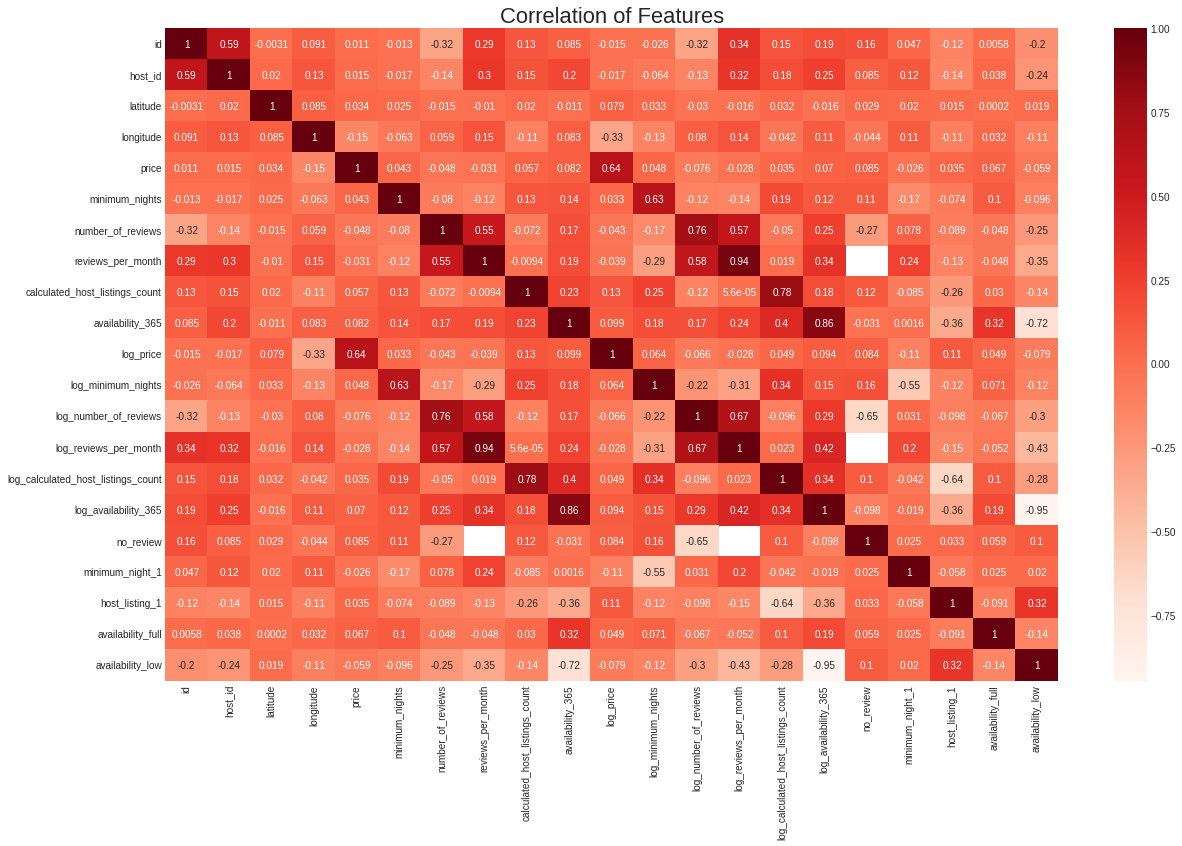

In [157]:
plt.figure(figsize=(20,12))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.title("Correlation of Features", fontsize = 22)
plt.show()

# **Data Pre-processing**

**Deal with missing values**

In [158]:
# impute the null values in reviews_per_month and log__review_per_month with zero
df['reviews_per_month'].fillna(value=0, inplace=True)
print('Reviews_per_month column with null values:',df['reviews_per_month'].isnull().sum(), sep = '\n')
df['log_reviews_per_month'].fillna(value=0, inplace=True)
print('Log_Reviews_per_month column with null values:',df['log_reviews_per_month'].isnull().sum(), sep = '\n')

Reviews_per_month column with null values:
0
Log_Reviews_per_month column with null values:
0


In [159]:
# drop unwwanted features
df.drop(['id','host_name','last_review'], axis = 1,inplace=True) 
df.head()

,name,host_id,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,...,log_minimum_nights,log_number_of_reviews,log_reviews_per_month,log_calculated_host_listings_count,log_availability_365,no_review,minimum_night_1,host_listing_1,availability_full,availability_low
0,Clean & quiet apt home by the park,2787,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,...,0.693147,2.302585,0.190620,1.945910,5.902633,0,1,0,1,0
1,Skylit Midtown Castle,2845,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,...,0.693147,3.828641,0.322083,1.098612,5.874931,0,1,0,0,0
2,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,...,1.386294,0.000000,0.000000,0.693147,5.902633,1,0,1,1,0
3,Cozy Entire Floor of Brownstone,4869,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,...,0.693147,5.602119,1.729884,0.693147,5.273000,0,1,1,0,0
4,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,...,2.397895,2.302585,0.095310,0.693147,0.000000,0,0,1,0,1


**Deal with outliers**

Text(0.5, 1.0, 'host listings count')

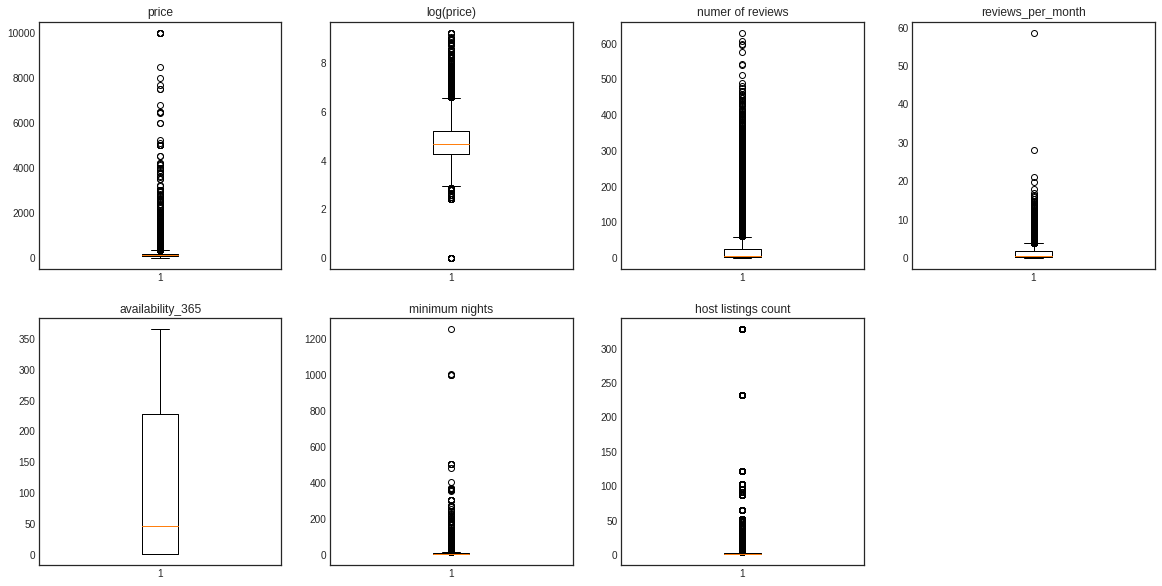

In [160]:
# visualize data and check outliers
plt.figure(figsize = (20, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(241)
plt.boxplot(df['price'])
ax.set_title('price')
ax=plt.subplot(242)
plt.boxplot(df['log_price'])
ax.set_title('log(price)')
ax=plt.subplot(243)
plt.boxplot(df['number_of_reviews'])
ax.set_title('numer of reviews')
ax=plt.subplot(244)
plt.boxplot(df['reviews_per_month'])
ax.set_title('reviews_per_month')
ax=plt.subplot(245)
plt.boxplot(df['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(246)
plt.boxplot(df['minimum_nights'])
ax.set_title('minimum nights')
ax=plt.subplot(247)
plt.boxplot(df['calculated_host_listings_count'])
ax.set_title('host listings count')

Normally, any observations that are more than 1.5 IQR below Q1 or more than 1.5 IQR above Q3 are considered outliers. In this case, we can see that except availability_365, all other numerical factors have the huge amount of outliers. However, such huge amount of outliers sometimes can be useful info that reflect the underlying distribution. For the log_price - the target variable that we will use, 22% belongs to "outlier" category and this proportion is tremendous. So we would love to create 2 scenarios to test out:


1.   Consider such 22% data as outliers => remove them
2.  Consider such 22% data as useful info for prediction => keep them



In [161]:
# remove outliers
Q1 = df['log_price'].quantile(0.25)
Q3 = df['log_price'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df['log_price'] >= Q1 - 1.5 * IQR) & (df['log_price'] <= Q3 + 1.5 *IQR)
df1 = df.loc[filter]

Q1 = df1['number_of_reviews'].quantile(0.25)
Q3 = df1['number_of_reviews'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df1['number_of_reviews'] >= Q1 - 1.5 * IQR) & (df1['number_of_reviews'] <= Q3 + 1.5 *IQR)
df2 = df1.loc[filter]

Q1 = df2['reviews_per_month'].quantile(0.25)
Q3 = df2['reviews_per_month'].quantile(0.75)
IQR = Q3 - Q1    #IQR is interquartile range. 
filter = (df2['reviews_per_month'] >= Q1 - 1.5 * IQR) & (df2['reviews_per_month'] <= Q3 + 1.5 *IQR)
df_wo_outlier = df2.loc[filter]

In [162]:
# check % data removed
1-len(df_wo_outlier)/len(df)

0.22120871254729524

Text(0.5, 1.0, 'host listings count')

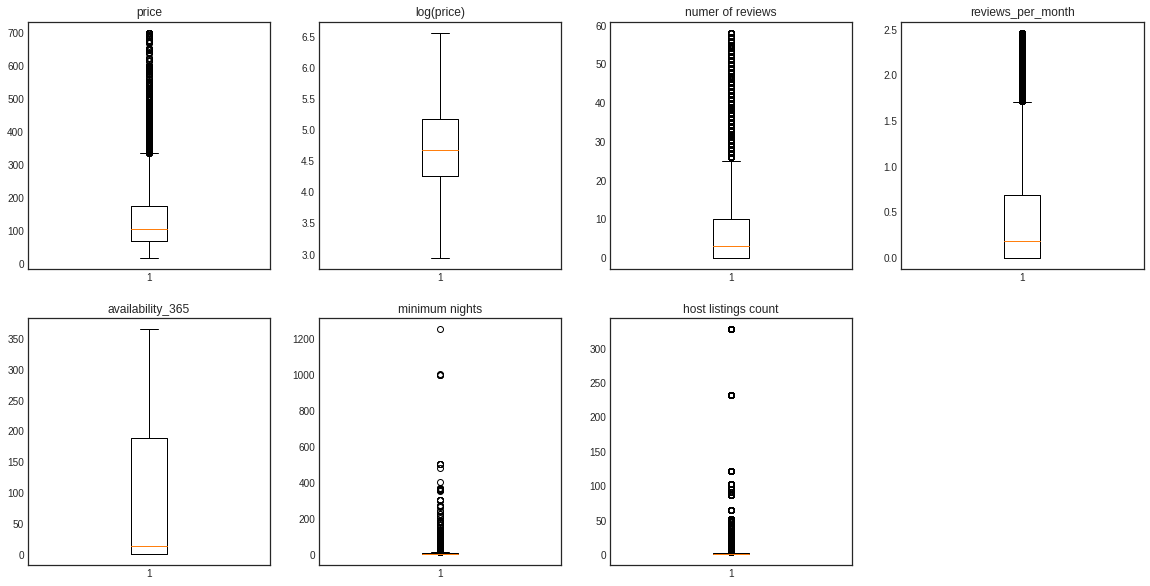

In [163]:
# check outliers again
plt.figure(figsize = (20, 10))
plt.style.use('seaborn-white')
ax=plt.subplot(241)
plt.boxplot(df_wo_outlier['price'])
ax.set_title('price')
ax=plt.subplot(242)
plt.boxplot(df_wo_outlier['log_price'])
ax.set_title('log(price)')
ax=plt.subplot(243)
plt.boxplot(df_wo_outlier['number_of_reviews'])
ax.set_title('numer of reviews')
ax=plt.subplot(244)
plt.boxplot(df_wo_outlier['reviews_per_month'])
ax.set_title('reviews_per_month')
ax=plt.subplot(245)
plt.boxplot(df_wo_outlier['availability_365'])
ax.set_title('availability_365')
ax=plt.subplot(246)
plt.boxplot(df_wo_outlier['minimum_nights'])
ax.set_title('minimum nights')
ax=plt.subplot(247)
plt.boxplot(df_wo_outlier['calculated_host_listings_count'])
ax.set_title('host listings count')

In [164]:
'''
# As can be seen from the graph of log-price distribution above, values in the range of 3 to 8 are the more 'reasonable' data. So we remove the data outside that range.
# remove outliers - log(price) version_0
df = df[np.log1p(df['price']) < 8]
df = df[np.log1p(df['price']) > 3]
df['log_price'] = np.log1p(df['price'])
'''

"\n# As can be seen from the graph of log-price distribution above, values in the range of 3 to 8 are the more 'reasonable' data. So we remove the data outside that range.\n# remove outliers - log(price) version_0\ndf = df[np.log1p(df['price']) < 8]\ndf = df[np.log1p(df['price']) > 3]\ndf['log_price'] = np.log1p(df['price'])\n"

**Convert categorical data**

In [165]:
def encode_cat_var(df):
  ''' Input: dataframe containing 2 categorical variables: neighbourhood_group, room_type
      Output: feature dataframe with 1 hot encoded values of such categorical variables
  '''
  # one hot encoding
  dummy_neighbourhood=pd.get_dummies(df['neighbourhood_group'], prefix='dummy')
  dummy_roomtype=pd.get_dummies(df['room_type'], prefix='dummy')
  # get the feature column names
  col_names = list(df.columns)
  target_names = {'price', 'log_price'}
  feature_names = [ele for ele in col_names if ele not in target_names]
  # create dataframe with encoding values
  encoded_features = df[feature_names]
  encoded_features = pd.concat([encoded_features,dummy_neighbourhood,dummy_roomtype],axis=1)
  encoded_features.drop(['neighbourhood_group','room_type','name','neighbourhood'],axis=1, inplace=True)
  return encoded_features

In [166]:
# Encoding df
feature_df = encode_cat_var(df)
feature_df.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,0.693147,2.302585,...,1,0,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0.693147,3.828641,...,0,0,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,1.386294,0.000000,...,1,0,0,0,1,0,0,0,1,0
3,4869,40.68514,-73.95976,1,270,4.64,1,194,0.693147,5.602119,...,0,0,0,1,0,0,0,1,0,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,2.397895,2.302585,...,0,1,0,0,1,0,0,1,0,0


In [167]:
# Encoding df without outliers
feature_df_wo_outlier = encode_cat_var(df_wo_outlier)
feature_df_wo_outlier.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,2787,40.64749,-73.97237,1,9,0.21,6,365,0.693147,2.302585,...,1,0,0,1,0,0,0,0,1,0
1,2845,40.75362,-73.98377,1,45,0.38,2,355,0.693147,3.828641,...,0,0,0,0,1,0,0,1,0,0
2,4632,40.80902,-73.94190,3,0,0.00,1,365,1.386294,0.000000,...,1,0,0,0,1,0,0,0,1,0
4,7192,40.79851,-73.94399,10,9,0.10,1,0,2.397895,2.302585,...,0,1,0,0,1,0,0,1,0,0
6,7356,40.68688,-73.95596,45,49,0.40,1,0,3.828641,3.912023,...,0,1,0,1,0,0,0,0,1,0


In [112]:
'''
# Encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder() # Fit label encoder
le.fit(df_new['neighbourhood_group'])
df_new['neighbourhood_group']=le.transform(df_new['neighbourhood_group']) # Transform labels to normalized encoding.

le = preprocessing.LabelEncoder()
le.fit(df_new['neighbourhood'])
df_new['neighbourhood']=le.transform(df_new['neighbourhood'])

le = preprocessing.LabelEncoder()
le.fit(df_new['room_type'])
df_new['room_type']=le.transform(df_new['room_type'])

df_new.sort_values(by='price',ascending=True,inplace=True)

df_new.head()
'''

"\n# Encode labels with value between 0 and n_classes-1.\nle = preprocessing.LabelEncoder() # Fit label encoder\nle.fit(df_new['neighbourhood_group'])\ndf_new['neighbourhood_group']=le.transform(df_new['neighbourhood_group']) # Transform labels to normalized encoding.\n\nle = preprocessing.LabelEncoder()\nle.fit(df_new['neighbourhood'])\ndf_new['neighbourhood']=le.transform(df_new['neighbourhood'])\n\nle = preprocessing.LabelEncoder()\nle.fit(df_new['room_type'])\ndf_new['room_type']=le.transform(df_new['room_type'])\n\ndf_new.sort_values(by='price',ascending=True,inplace=True)\n\ndf_new.head()\n"

**Standardize the dataset**

In [168]:
def normalize_features(feature_df):
  ''' Input: dataframe of features
      Output: dataframe of features with normalized values
  '''
  # normalize the data
  X = preprocessing.scale(feature_df)
  # convert normalized data array into dataframe
  X = pd.DataFrame(X)
  col_name_map = {k: v for k, v in enumerate(list(feature_df.columns))}
  X=X.rename(index=str, columns=col_name_map)
  return X

In [169]:
# Normalize feature_df
feature_df = normalize_features(feature_df)
feature_df.head()

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_data.py:235: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn(


,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,-0.860159,-1.493849,-0.437652,-0.293996,-0.320414,-0.551511,-0.034716,1.916250,-0.927478,0.199346,...,6.062735,-0.843203,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,-1.040134,1.090893,-0.155887
1,-0.860158,0.452436,-0.684639,-0.293996,0.487665,-0.445079,-0.156104,1.840275,-0.927478,1.174979,...,-0.164942,-0.843203,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.961415,-0.916680,-0.155887
2,-0.860135,1.468399,0.222497,-0.196484,-0.522433,-0.682986,-0.186451,1.916250,-0.130587,-1.272736,...,6.062735,-0.843203,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,-1.040134,1.090893,-0.155887
3,-0.860132,-0.803398,-0.164450,-0.293996,5.538156,2.221978,-0.186451,0.617065,-0.927478,2.308793,...,-0.164942,-0.843203,-0.151071,1.196705,-0.891833,-0.362035,-0.087677,0.961415,-0.916680,-0.155887
4,-0.860103,1.275660,0.177216,0.144807,-0.320414,-0.620379,-0.186451,-0.856865,1.032421,0.199346,...,-0.164942,1.185954,-0.151071,-0.835628,1.121286,-0.362035,-0.087677,0.961415,-0.916680,-0.155887


In [171]:
# Normalize feature_df without the outliers
feature_df_wo_outlier = normalize_features(feature_df_wo_outlier)
feature_df_wo_outlier.head()

,host_id,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,log_minimum_nights,log_number_of_reviews,...,availability_full,availability_low,dummy_Bronx,dummy_Brooklyn,dummy_Manhattan,dummy_Queens,dummy_Staten Island,dummy_Entire home/apt,dummy_Private room,dummy_Shared room
0,-0.841170,-1.508363,-0.421415,-0.314694,0.066561,-0.408292,-0.057382,2.016157,-0.989869,0.677826,...,5.763067,-0.992491,-0.14328,1.188039,-0.907198,-0.346225,-0.082108,-1.034008,1.086073,-0.158397
1,-0.841169,0.448921,-0.681608,-0.314694,3.041601,-0.121548,-0.171971,1.940206,-0.989869,1.928804,...,-0.173519,-0.992491,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,0.967110,-0.920748,-0.158397
2,-0.841145,1.470626,0.274033,-0.225428,-0.677199,-0.762506,-0.200618,2.016157,-0.231059,-1.209707,...,5.763067,-0.992491,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,-1.034008,1.086073,-0.158397
3,-0.841112,1.276797,0.226331,0.087006,0.066561,-0.593832,-0.200618,-0.756042,0.876371,0.677826,...,-0.173519,1.007566,-0.14328,-0.841723,1.102295,-0.346225,-0.082108,0.967110,-0.920748,-0.158397
4,-0.841110,-0.781920,-0.046873,1.649171,3.372161,-0.087813,-0.200618,-0.756042,2.442652,1.997155,...,-0.173519,1.007566,-0.14328,1.188039,-0.907198,-0.346225,-0.082108,-1.034008,1.086073,-0.158397


In [172]:
# Get the target variables
y = df.log_price
print(y)
y_wo_outlier = df_wo_outlier.log_price
print(y_wo_outlier)

# check length of features & target variables
if len(feature_df) == len(y):
  print("check 1:",True)
else: 
  print(False)

if len(feature_df_wo_outlier) == len(y_wo_outlier):
  print("check 2:", True)
else: 
  print(False)

0        5.010635
1        5.420535
2        5.017280
3        4.499810
4        4.394449
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: log_price, Length: 48895, dtype: float64
0        5.010635
1        5.420535
2        5.017280
4        4.394449
6        4.110874
           ...   
48890    4.262680
48891    3.713572
48892    4.753590
48893    4.025352
48894    4.510860
Name: log_price, Length: 38079, dtype: float64
check 1: True
check 2: True


**Feature importance**

https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

In [199]:
X = feature_df.to_numpy()
X_wo_outlier = feature_df_wo_outlier.to_numpy()

In [209]:
# random forest for feature importance on a regression problem
def feature_imp_dt(feature_name_list, X , y):
  ''' Input: list of feature names, feature values, target values
      Output: importance score for each feature
  '''
  # get the model
  model = RandomForestRegressor()
  model.fit(X, y)
  # get importance
  importance = model.feature_importances_
  # summarize feature importance
  for i,v in enumerate(importance):
    feature_name = feature_name_list[i]
    print('Feature {} ({}): Score: {}'.format(i,feature_name,v))
  # plot feature importance
  plt.bar([x for x in range(len(importance))], importance)
  plt.show()

Feature 0 (host_id): Score: 0.07980854160625972
Feature 1 (latitude): Score: 0.12780817079596168
Feature 2 (longitude): Score: 0.13748621623698065
Feature 3 (minimum_nights): Score: 0.023637422187482642
Feature 4 (number_of_reviews): Score: 0.018050535107494225
Feature 5 (reviews_per_month): Score: 0.02339667993941452
Feature 6 (calculated_host_listings_count): Score: 0.013343108027267542
Feature 7 (availability_365): Score: 0.03536986565963988
Feature 8 (log_minimum_nights): Score: 0.02338648607388871
Feature 9 (log_number_of_reviews): Score: 0.0184676885971499
Feature 10 (log_reviews_per_month): Score: 0.023528540436299775
Feature 11 (log_calculated_host_listings_count): Score: 0.013181815758999895
Feature 12 (log_availability_365): Score: 0.03480903872927618
Feature 13 (no_review): Score: 0.0032856558514090376
Feature 14 (minimum_night_1): Score: 0.003209218946680291
Feature 15 (host_listing_1): Score: 0.0030546009880985906
Feature 16 (availability_full): Score: 0.000718345373063589

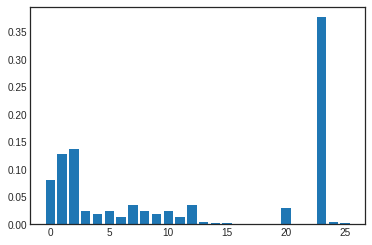

In [210]:
# check feature importance
feature_imp_dt(list(feature_df.columns),X,y)

Feature 0 (host_id): Score: 0.07439120124447943
Feature 1 (latitude): Score: 0.12488566143510367
Feature 2 (longitude): Score: 0.12954215942604227
Feature 3 (minimum_nights): Score: 0.02259007916372017
Feature 4 (number_of_reviews): Score: 0.01539651231797944
Feature 5 (reviews_per_month): Score: 0.020988981084688055
Feature 6 (calculated_host_listings_count): Score: 0.011744766839331936
Feature 7 (availability_365): Score: 0.0301015189880604
Feature 8 (log_minimum_nights): Score: 0.021943956622915362
Feature 9 (log_number_of_reviews): Score: 0.015084858047149822
Feature 10 (log_reviews_per_month): Score: 0.02187303748829376
Feature 11 (log_calculated_host_listings_count): Score: 0.011733383687635043
Feature 12 (log_availability_365): Score: 0.02912267659226005
Feature 13 (no_review): Score: 0.0017679900117846916
Feature 14 (minimum_night_1): Score: 0.002579261686649253
Feature 15 (host_listing_1): Score: 0.0030613532222748385
Feature 16 (availability_full): Score: 0.000560636597848108

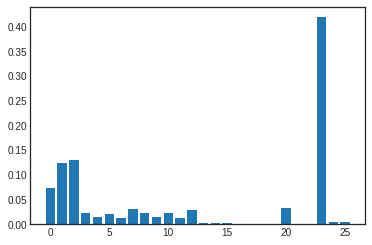

In [211]:
# check feature importance for data without outliers
feature_imp_dt(list(feature_df.columns),X_wo_outlier,y_wo_outlier)

From these feature dataframes, the target variable and hints on feature importance, we can test out 2 scenarios with different combination of features.


# **Modeling**

Scenario 1: outliers are not removed

Scenario 2: outliers are removed